# An√°lise de Reten√ß√£o

Neste projeto, analiso o comportamento de reten√ß√£o de clientes ao longo do tempo utilizando an√°lise de coorte, curva de sobreviv√™ncia de Kaplan-Meier, funil de reten√ß√£o e Churn.

A base simula assinaturas mensais recorrentes, com foco em identificar padr√µes de churn e oportunidades de fideliza√ß√£o.

A an√°lise resultou em insights estrat√©gicos para reten√ß√£o e fideliza√ß√£o, com destaque para os primeiros 3 meses cr√≠ticos, oportunidades de upgrade ap√≥s o 4¬∫ m√™s e a necessidade de monitoramento ativo entre os meses 6 e 9.

In [52]:
#Importar as bibliotecas necess√°rias (usando o Colab):
import pandas as pd
from google.colab import files
from google.colab import drive
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [53]:
#Vincular ao caminho do drive que consta minha planilha e puxei o arquivo (voc√™ deve montar o drive e ajustar o caminho do arquivo, caso use seu notebook em outro ambiente):
drive.mount('/content/drive')
caminho_arquivo = '/content/drive/MyDrive/Dados para an√°lise/Cohort/base_fake_assinaturas.xlsx'
df = pd.read_excel(caminho_arquivo)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data_assinatura id_cliente  cancelado data_cancelamento  valor_mensal  \
0      2024-06-12     C00000          0               NaT        101.78   
1      2024-03-19     C00001          1        2024-06-24         53.47   
2      2024-05-20     C00002          0               NaT         76.15   
3      2024-04-12     C00003          0               NaT        127.83   
4      2024-04-12     C00004          0               NaT        144.61   

  motivo_cancelamento  
0                 NaN  
1               Pre√ßo  
2                 NaN  
3                 NaN  
4                 NaN

In [54]:
# Garantir que as datas est√£o no formato datetime
df['data_assinatura'] = pd.to_datetime(df['data_assinatura'])
df['data_cancelamento'] = pd.to_datetime(df['data_cancelamento'])

In [55]:
# Criar o m√™s de coorte (m√™s de entrada) O 'W' significa que queremos agrupar por m√™s.
df['mes_coorte'] = df['data_assinatura'].dt.to_period('M').apply(lambda r: r.start_time)

# Gerar um dataframe auxiliar com todas as semanas entre entrada e cancelamento (ou data limite)
data_limite = df['data_assinatura'].min() + pd.DateOffset(months=11)


In [56]:
# Criar lista de linhas com cliente ativo por m√™s (ajustada)
linhas = []

for _, row in df.iterrows():
    entrada = row['data_assinatura']
    cancelamento = row['data_cancelamento'] if pd.notnull(row['data_cancelamento']) else data_limite

    # Garantir que come√ßa no in√≠cio do m√™s da entrada
    entrada_inicio_mes = entrada.replace(day=1)

    meses_ativos = pd.date_range(start=entrada_inicio_mes, end=cancelamento, freq='MS')

    for mes in meses_ativos:
        linhas.append({
            'id_cliente': row['id_cliente'],
            'mes_coorte': row['data_assinatura'].to_period('M').start_time,
            'mes_observacao': mes
        })


In [57]:
#Criar expans√£o
df_expansao = pd.DataFrame(linhas)

# Calcular o n√∫mero de meses desde a entrada (M0, M1, M2...)
df_expansao['mes_relativo'] = (
    (df_expansao['mes_observacao'].dt.year - df_expansao['mes_coorte'].dt.year) * 12 +
    (df_expansao['mes_observacao'].dt.month - df_expansao['mes_coorte'].dt.month)
)


In [58]:
#Garantir que cada cliente conte apenas uma vez por m√™s relativo
df_expansao = df_expansao.drop_duplicates(subset=['id_cliente', 'mes_coorte', 'mes_relativo'])


df_expansao['mes_relativo'].value_counts().sort_index()

df_expansao['mes_relativo'].value_counts().sort_index()


mes_relativo
0     950
1     921
2     833
3     753
4     705
5     688
6     688
7     603
8     435
9     307
10    208
11     99
Name: count, dtype: int64

In [59]:
# Contar n√∫mero de clientes √∫nicos por coorte e m√™s relativo
cohort_data = df_expansao.groupby(['mes_coorte', 'mes_relativo'])['id_cliente'].nunique().reset_index()

# Total de clientes por coorte (M0)
cohort_sizes = cohort_data[cohort_data['mes_relativo'] == 0][['mes_coorte', 'id_cliente']]
cohort_sizes = cohort_sizes.rename(columns={'id_cliente': 'total_coorte'})

# Juntar os tamanhos com o restante
cohort_data = pd.merge(cohort_data, cohort_sizes, on='mes_coorte')

# Calcular a taxa de reten√ß√£o (%)
cohort_data['retencao'] = cohort_data['id_cliente'] / cohort_data['total_coorte']

# Transformar em matriz para visualiza√ß√£o
matriz_retencao = cohort_data.pivot(index='mes_coorte', columns='mes_relativo', values='retencao')

# Visualizar as primeiras linhas formatadas
matriz_retencao.style.format("{:.0%}")


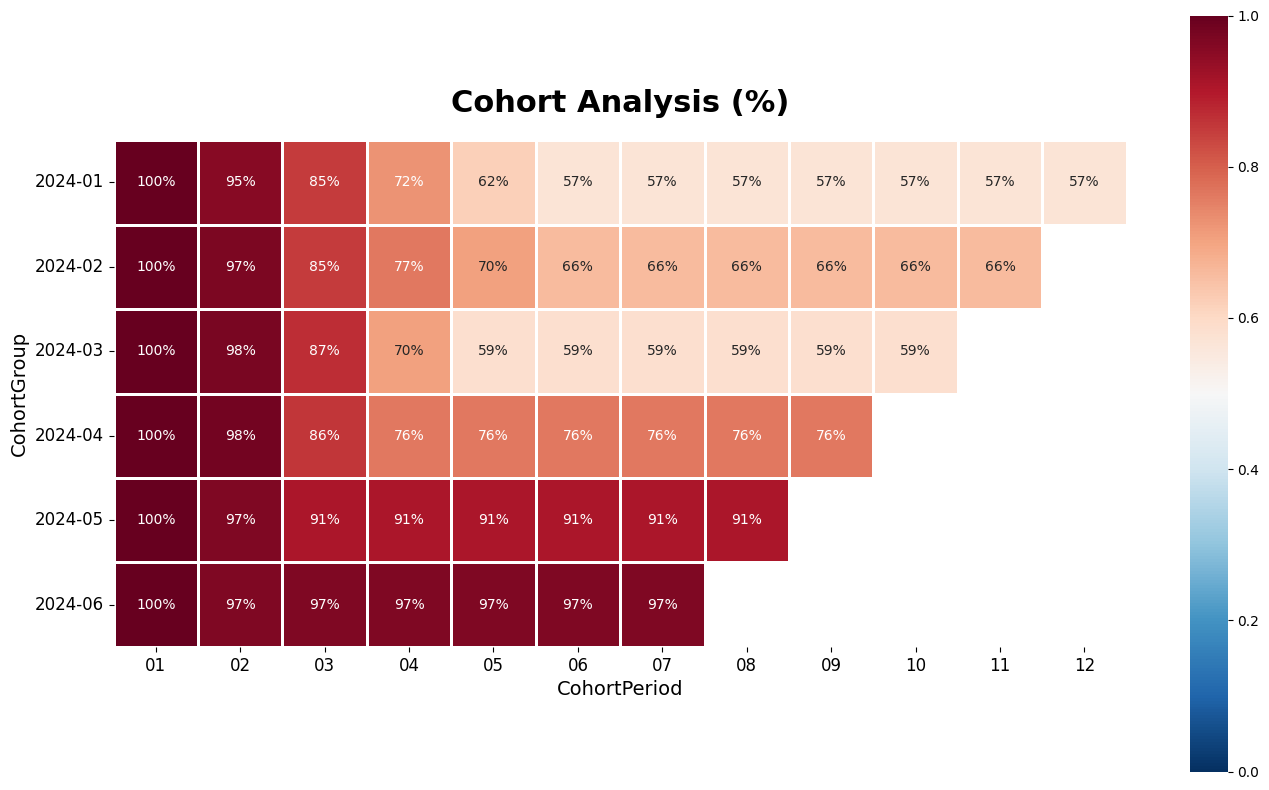

In [60]:

# Garantir que o index e colunas estejam no formato adequado
matriz_formatada = matriz_retencao.copy()
matriz_formatada.index = matriz_formatada.index.strftime('%Y-%m')  # remove T00:00...
matriz_formatada.columns.name = 'Per√≠odo'
matriz_formatada.columns = [f"{col+1:02}" for col in matriz_formatada.columns]
matriz_formatada.index.name = 'M√™s de Refer√™ncia'

plt.figure(figsize=(14, 8))

sns.heatmap(
    matriz_formatada,
    annot=True,
    fmt=".0%",
    cmap="RdBu_r",
    cbar=True,
    linewidths=1,
    linecolor='white',
    vmin=0, vmax=1,
    square=True  # ‚Üê Deixa cada c√©lula em propor√ß√£o quadrada
)

plt.title("Cohort Analysis (%)", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("CohortPeriod", fontsize=14)
plt.ylabel("CohortGroup", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

### O gr√°fico acima mostra a taxa de reten√ß√£o dos clientes m√™s a m√™s ap√≥s sua entrada. Ele indica o qu√£o bem as coortes est√£o mantendo seus clientes ao longo do tempo.

*As cores v√£o do vermelho escuro (alta reten√ß√£o) ao branco (baixa), e cada linha representa uma coorte (grupo de clientes que entrou no mesmo m√™s). As colunas representam os meses desde a entrada (CohortPeriod).*

**Podemos perceber que a primeira grande queda ocorre no 2¬∫ ao 4¬∫ m√™s para coortes mais antigas (jan a mar/24):**

Coorte de Janeiro: cai de 100% ‚Üí 72% em 3 meses.
Coorte de Mar√ßo: de 100% ‚Üí 59% em 4 meses.

üîé *Sinal de problema no in√≠cio do ciclo de vida.*

**Melhoria de reten√ß√£o nas coortes recentes (mai e jun/24):**

Coorte de Maio mant√©m 91% at√© o 8¬∫ m√™s.
Junho ret√©m 97% por 7 meses seguidos.

üü¢ *Sugere melhoria nas estrat√©gias de onboarding ou produto. Recomendo analisar o que foi feito de estrat√©gia durantes esses meses.*

**üéØ A√ß√µes ou recomenda√ß√µes:**

Investigar os primeiros 3 meses de jornada: Onde a maioria abandona ‚Äî avaliar onboarding, valor percebido, suporte.

Replicar pr√°ticas das coortes mais recentes: Algo mudou (ex: comunica√ß√£o, b√¥nus, melhorias?) que manteve mais clientes ativos.

Criar a√ß√µes espec√≠ficas de engajamento nos meses cr√≠ticos (2 a 4): Pushs, ofertas, onboarding refor√ßado.

Monitorar se as coortes recentes mant√™m a boa reten√ß√£o com o tempo.





M√©dia de tempo de reten√ß√£o: 7.57 meses
Mediana de tempo de reten√ß√£o: 8.00 meses


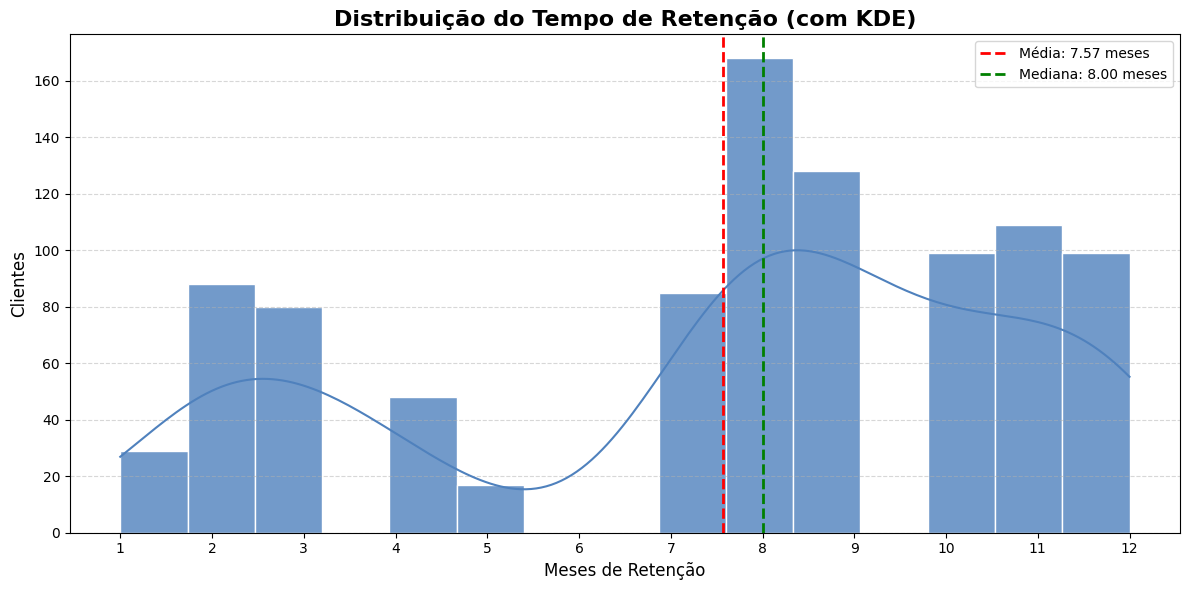

In [63]:
# Calcular tempo m√°ximo de reten√ß√£o por cliente
tempo_por_cliente = df_expansao.groupby('id_cliente')['mes_relativo'].max() + 1  # ‚¨ÖÔ∏è Aqui somamos +1

# Calcular m√©dia e mediana
media_tempo = tempo_por_cliente.mean()
mediana_tempo = tempo_por_cliente.median()

# Mostrar os valores
print(f"M√©dia de tempo de reten√ß√£o: {media_tempo:.2f} meses")
print(f"Mediana de tempo de reten√ß√£o: {mediana_tempo:.2f} meses")

plt.figure(figsize=(12, 6))
sns.histplot(tempo_por_cliente, kde=True, color="#4F81BD", bins=15, edgecolor="white", alpha=0.8)

# Linhas de m√©dia e mediana
plt.axvline(media_tempo, color='red', linestyle='--', linewidth=2, label=f'M√©dia: {media_tempo:.2f} meses')
plt.axvline(mediana_tempo, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana_tempo:.2f} meses')

# Est√©tica
plt.title("Distribui√ß√£o do Tempo de Reten√ß√£o (com KDE)", fontsize=16, fontweight='bold')
plt.xlabel("Meses de Reten√ß√£o", fontsize=12)
plt.ylabel("Clientes", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(range(1, tempo_por_cliente.max() + 1))  # ‚Üê for√ßa ticks de 1 at√© o valor m√°ximo
plt.tight_layout()
plt.show()



### O Histograma com curva de densidade (KDE) apresenta a distribui√ß√£o de tempo de vida dos clientes em meses, ou seja, por quanto tempo os clientes permanecem ativos antes de cancelarem ou inativarem.

*A linha vermelha representa a m√©dia e a linha verde a mediana do tempo de reten√ß√£o.*

Podemos perceber que a reten√ß√£o m√©dia e a mediana s√£o altas. M√©dia ‚âà 7,6 meses, Mediana ‚âà 8 meses.
‚úÖ Sinal positivo: mais da metade dos clientes permanece por at√© 8 meses.

**Temos uma distribui√ß√£o bimodal:**

Um pico nos primeiros meses (1 a 3) e outro pico entre 8 a 12 meses.
üîç Isso indica dois comportamentos distintos: clientes que saem rapidamente e clientes que permanecem bastante tempo. Refor√ßando o que identificamos no primeiro gr√°fico.

üéØ **O que este gr√°fico sugere:**
A base fiel de clientes tem comportamento robusto ‚Äî vale a pena estudar esse grupo para entender o que os mant√©m.

Pode ser interessante segmentar estrat√©gias: uma para novos clientes (ativa√ß√£o) e outra para clientes longevos (recompensa, upsell, fideliza√ß√£o).




In [78]:
!pip install lifelines
from lifelines import KaplanMeierFitter


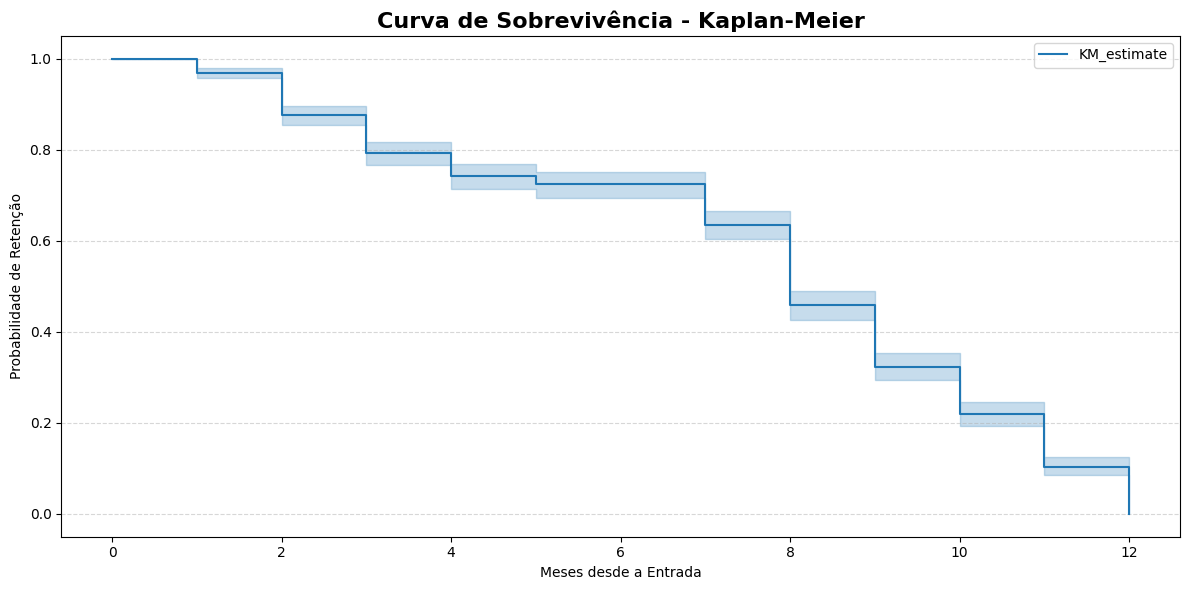

In [79]:
# Obter o tempo de reten√ß√£o final por cliente
tempo_vida = df_expansao.groupby('id_cliente')['mes_relativo'].max().reset_index()
tempo_vida['meses_ativos'] = tempo_vida['mes_relativo'] + 1  # Ajustar M0 ‚Üí m√™s 1

# Supondo que todos os clientes sa√≠ram (sem censura)
tempo_vida['evento_ocorreu'] = True  # 1 para evento (churn)

kmf = KaplanMeierFitter()
kmf.fit(durations=tempo_vida['meses_ativos'], event_observed=tempo_vida['evento_ocorreu'])

plt.figure(figsize=(12, 6))
kmf.plot(ci_show=True)
plt.title("Curva de Sobreviv√™ncia - Kaplan-Meier", fontsize=16, fontweight='bold')
plt.xlabel("Meses desde a Entrada")
plt.ylabel("Probabilidade de Reten√ß√£o")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Esse gr√°fico mostra a Curva de Sobreviv√™ncia dos clientes usando o m√©todo Kaplan-Meier, que √© comumente utilizado em an√°lises de churn e tempo de vida de clientes.

*Eixo X: Meses desde a entrada do cliente (tempo desde o in√≠cio da assinatura).
Eixo Y: Probabilidade acumulada de um cliente ainda estar ativo (n√£o ter churnado) at√© aquele m√™s.*

Podemos perceber que o Churn precoce √© cr√≠tico, visto que a maioria dos clientes s√£o perdidos nos primeiros meses e a reten√ß√£o de longo prazo √© baixa, j√° que a maior parte dos clientes n√£o permanecem por mais de 12 meses.

**A√ß√µes estruturadas nos primeiros meses podem ter grande impacto no LTV e reten√ß√£o geral. Recomendo focar no onboarding e engajamento nos 3 primeiros meses e analisar a causa inicial desses chur para definir a√ß√µes, criando campanhas de reten√ß√£o espec√≠ficas.**



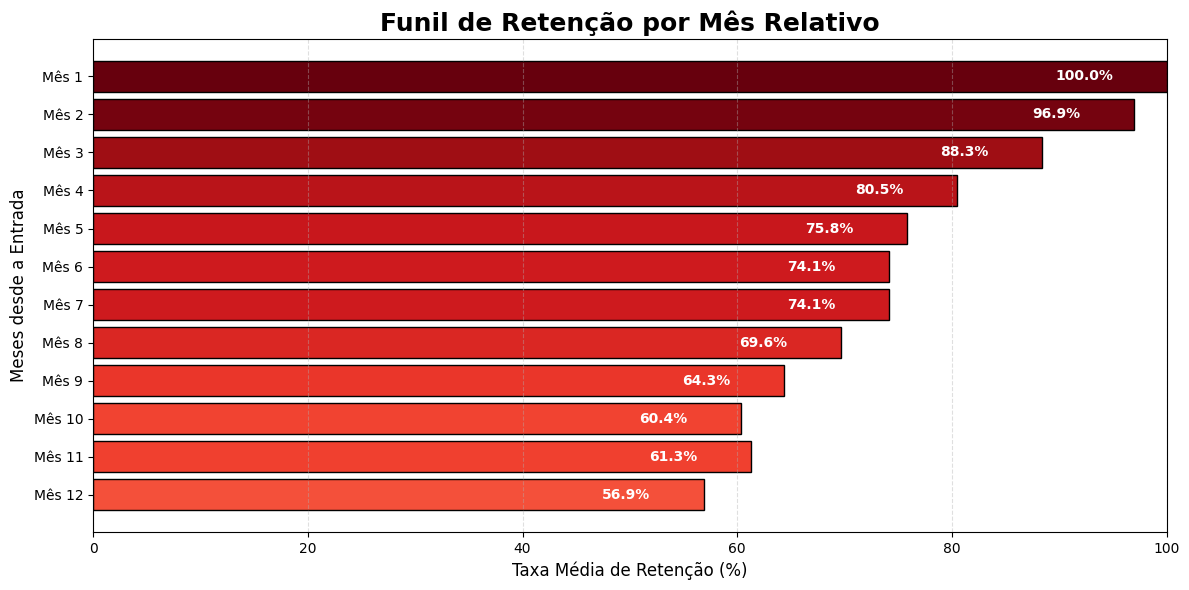

In [81]:
# Converter valores para porcentagem m√©dia de reten√ß√£o por m√™s relativo
retencao_media_por_mes = matriz_retencao.mean().sort_index() * 100

# Plotar o gr√°fico de funil horizontal
plt.figure(figsize=(12, 6))
bars = plt.barh(
    y=[f"M√™s {i+1}" for i in retencao_media_por_mes.index],
    width=retencao_media_por_mes.values,
    color=plt.cm.Reds(retencao_media_por_mes.values / 100),
    edgecolor='black'
)

# Adicionar os valores nas barras
for bar in bars:
    plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.1f}%", va='center', ha='right',
             fontsize=10, color='white', fontweight='bold')

# Est√©tica
plt.title("Funil de Reten√ß√£o por M√™s Relativo", fontsize=18, fontweight='bold')
plt.xlabel("Taxa M√©dia de Reten√ß√£o (%)", fontsize=12)
plt.ylabel("Meses desde a Entrada", fontsize=12)
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.gca().invert_yaxis()  # Inverter eixo para parecer um funil
plt.tight_layout()
plt.show()


### Esse gr√°fico representa um Funil de Reten√ß√£o por M√™s Relativo, tamb√©m conhecido como Retention Funnel. Ele mostra, m√™s a m√™s desde a entrada do cliente, qual a porcentagem m√©dia de clientes ainda ativos.

*Eixo Y (vertical): Meses desde a entrada do cliente (m√™s 1 = entrada).*

*Eixo X (horizontal): Taxa m√©dia de reten√ß√£o em cada m√™s.*

*Barras horizontais: Representam a porcentagem m√©dia de clientes que permanecem ativos no m√™s correspondente.*

Esse gr√°fico evidencia o que j√° vimos em nossa an√°lise, por exemplo, que temos uma perda significativa nos primeiros meses, de 100% no m√™s 1 para 88,3% j√° no m√™s 3, indicando uma perda de ~12% em apenas 2 meses.

No m√™s 4, a reten√ß√£o j√° est√° em 80,5% ‚Üí √© um sinal de que os primeiros 3‚Äì4 meses s√£o cr√≠ticos para o churn.

Entretanto, temos leve estabiliza√ß√£o entre os meses 5 e 7, Pequenas quedas (de 75,8% para 74,1%) mostram que quem passou do m√™s 4 tende a permanecer por mais tempo e retornamos a queda significativa entre os meses 8 e 10, de modo que ao fim de 1 ano, apenas 56,9% dos clientes ainda est√£o ativos em m√©dia.

**Sendo assim, temos o refor√ßo de que Onboarding e engajamento nos primeiros 3 meses s√£o essenciais. Al√©m disso, clientes que passam do m√™s 4 t√™m mais propens√£o a se manter, ent√£o esse √© o momento ideal para oferecer planos de fideliza√ß√£o, upgrades ou recompensas.**

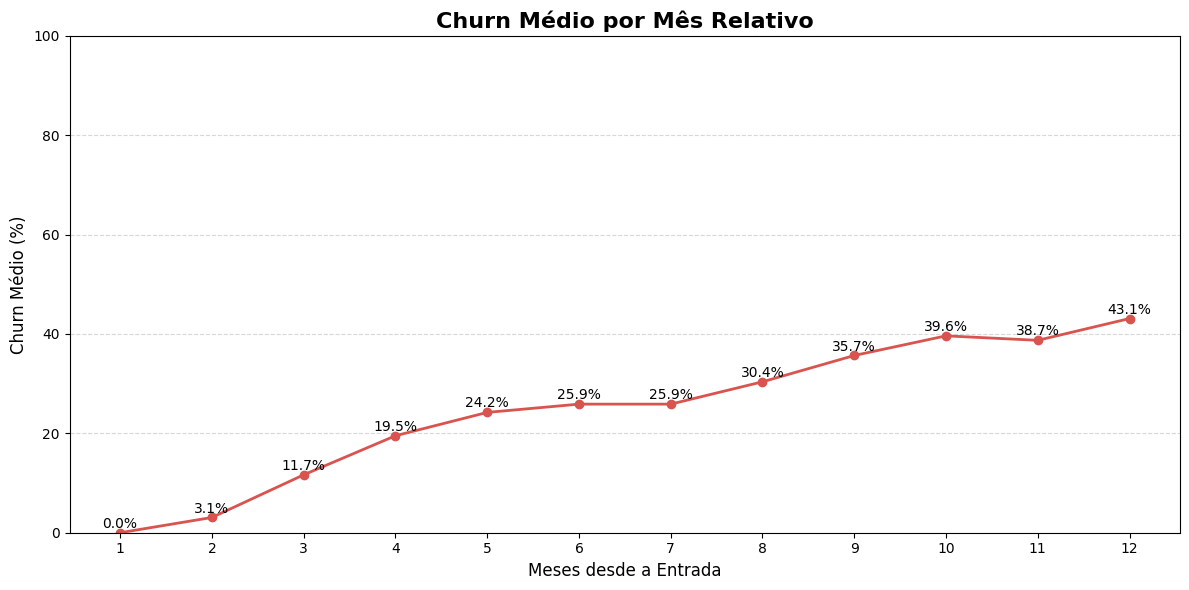

In [82]:
# Calcular taxa de churn como complemento da taxa de reten√ß√£o
churn_por_mes = 1 - matriz_retencao.mean().sort_index()

# Converter para porcentagem
churn_por_mes_percent = churn_por_mes * 100

# Plotar o gr√°fico
plt.figure(figsize=(12, 6))
plt.plot(
    churn_por_mes_percent.index + 1,  # ajusta M√™s 0 para M√™s 1
    churn_por_mes_percent.values,
    marker='o', linestyle='-', color='#D9534F', linewidth=2
)

# Adicionar valores nas marca√ß√µes
for i, value in enumerate(churn_por_mes_percent.values):
    plt.text(i + 1, value + 1, f"{value:.1f}%", ha='center', fontsize=10)

# Est√©tica
plt.title("Churn M√©dio por M√™s Relativo", fontsize=16, fontweight='bold')
plt.xlabel("Meses desde a Entrada", fontsize=12)
plt.ylabel("Churn M√©dio (%)", fontsize=12)
plt.xticks(range(1, len(churn_por_mes_percent) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


### O gr√°fico acima mostra o Churn M√©dio por M√™s Relativo, ou seja, a percentual acumulada de clientes que cancelaram ao longo dos meses desde a entrada na base.

*Eixo X: Meses desde a entrada do cliente (m√™s 1 = entrada).*

*Eixo Y: Porcentagem m√©dia de churn acumulado (%).*

Novamente identificamos abandono precore at√© o m√™s 3, talvez por falta de engajamento, onboarding ruim ou expectativas n√£o atendidas. Ent√£o precisamos identificar isso (analisando a pesquisa de cancelamento) para seguir com o plano de a√ß√£o adequado.

A curva √© crescente e cont√≠nua, o que √© t√≠pico de churn acumulado, mas a inclina√ß√£o mostra onde as maiores perdas ocorrem.

üìåEnt√£o conclu√≠mos essa an√°lise com as seguintes sugest√µes:

**1. Atua√ß√£o r√°pida nos primeiros 3 meses:**

Refor√ßar onboarding, comunica√ß√£o de valor e benef√≠cios.

Incentivos de reten√ß√£o (descontos, conte√∫do exclusivo, b√¥nus).

**2. Upgrade e fideliza√ß√£o entre o 4¬∞ e 5¬∞ m√™s:**

Clientes que passam do m√™s 4 t√™m mais propens√£o a se manter, como identificamos no funil de reten√ß√£o, ent√£o esse √© o momento ideal para oferecer planos de fideliza√ß√£o, upgrades ou recompensas.

**3. Monitoramento nos meses 6 a 9:**

Investigar gatilhos de churn (pesquisa, comportamento).

Implementar estrat√©gias de reengajamento (notifica√ß√µes, atualiza√ß√µes, promo√ß√µes).


**4. Benchmarking:**

Se o churn anual acima de 40% for alto comparado ao seu mercado, √© um sinal claro de alerta.

